/Users/yanyancheng/opt/anaconda3/envs/jnPython3.7.0_basemap/lib/python3.7/site-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/yanyancheng/opt/anaconda3/envs/jnPython3.7.0_basemap/lib/python3.7/site-packages/ipykernel_launcher.py:34: UserWarning: WARNING: missing_value not used since it
cannot be safely cast to variable data type
/Users/yanyancheng/opt/anaconda3/envs/jnPython3.7.0_basemap/lib/python3.7/site-packages/ipykernel_launcher.py:34: UserWarning: WARNING: missing_value not used since it
cannot be safely cast to variable data type
/Users/yanyancheng/opt/anaconda3/envs/jnPython3.7.0_basemap/lib/python3.7/site-packages/ipyke

0

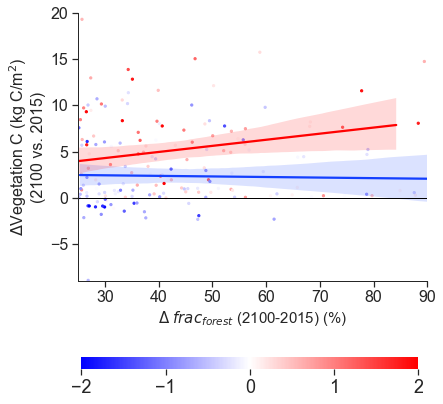

In [94]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import datetime
import csv
from netCDF4 import Dataset
from scipy import stats

import seaborn as sns
plt.style.use('seaborn-ticks')
sns.set_context("notebook", font_scale=1.5)

title_size  = 17
marker_size = 7
stepsize    = 0.01
label_size  = 15
border_size = 1.0
tick_size   = 16
legend_size = 10
line_width  = 0.5
rotation    = 45
text_size   = 10
unit_size   = 11
box_width   = 0.22
box_linewidth=1
max_min_markersize=3
markersize=50
alpha=1.0

def read_data(fname,var):
    pt=Dataset(fname, 'r')
    data=pt.variables[var][:]
    return data

def mask_data(forestdiff,data,bioenergydiff,diff_threshold):
    data=np.where(forestdiff<=diff_threshold, np.nan,data)
    data=np.where(bioenergydiff<=diff_threshold, np.nan,data)
    return data

def fillmissing(data,missVal):
    data=np.where(data>=missVal, np.nan,data)
    return data

def fillmissing_lucc(data):
    data=np.where(data>=1.00001, np.nan,data)
    data=np.where(data<0.0, np.nan,data)
    return data

def remove_nandata(forest,data):
    data=data[~np.isnan(forest)]
    return data

def set_label(ax_current,ssp,crop):
    ax_current.spines['top'].set_visible(False)
    ax_current.spines['right'].set_visible(False)
    ax_current.spines['bottom'].set_linewidth(border_size)
    ax_current.spines['left'].set_linewidth(border_size)
    ax_current.set_xlabel(r"$\Delta$"+" $frac$$_{forest}$ (2100-2015) (%)",fontsize=label_size)
    ax_current.set_ylabel(r"$\Delta$"+"Vegetation C (kg C/m$^2$)\n(2100 vs. 2015)",fontsize=label_size+1)

def read_one_ensemble(caseid):
    fname=data_dir +var+"_SSP126Lu-REFOREST_"+caseid+"_2015_2100.nc"
    vegc = read_data(fname, "value")
    vegc=fillmissing(vegc,missVal)
    vegc = vegc / 1000.
    diff=vegc[-1,:,:] - vegc[0,:,:]
    return diff

def subplot(ax,crop):
    frac_changes=True
    fname=data_dir + "forest_frac_2015_2100_SSP126Lu-REFOREST.nc"
    forest = read_data(fname, "biofrac")
    forest =fillmissing_lucc(forest)
    forest = forest *100.
    forestfrac=(forest[yeari_dic[2060],:,:] - forest[0,:,:])
    
    fname=data_dir + "bioenergy_frac_2015_2100_SSP226Lu-BIOCROP.nc"
    bioenergy = read_data(fname, "biofrac")
    bioenergy =fillmissing_lucc(bioenergy)
    bioenergy = bioenergy *100.
    bioenergydiff=(bioenergy[yeari_dic[2060],:,:] - bioenergy[0,:,:])

    ensbase=np.empty((ens_size,192,288))
    for caseid,i in zip(["ensemble1","ensemble2","ensemble3"],np.arange(ens_size)):
        ensbase[i,:,:] = read_one_ensemble(caseid)
    diffval = np.nanmean(ensbase,axis=0)
    
    forestfrac = forestfrac.reshape(nlat*nlon)
    forestdiff = forestfrac
    diffval = diffval.reshape(nlat*nlon)
    bioenergydiff = bioenergydiff.reshape(nlat*nlon)
        
    diff_threshold   = 25.0
    forestfrac = mask_data(forestdiff,forestfrac,bioenergydiff,diff_threshold)
    forestfrac = mask_data(forestdiff,forestfrac,bioenergydiff,diff_threshold)
    diffval = mask_data(forestdiff,diffval,bioenergydiff,diff_threshold)
    diffval = mask_data(forestdiff,diffval,bioenergydiff,diff_threshold)
    bioenergydiff = mask_data(forestdiff,bioenergydiff,bioenergydiff,diff_threshold)
    bioenergydiff=mask_data(forestdiff,bioenergydiff,bioenergydiff,diff_threshold)
        
    var2 = "TSA"
    ensbase=np.empty((ens_size,2,192,288))
    for caseid,i in zip(["ensemble1","ensemble2","ensemble3"],np.arange(ens_size)):
        fname=data_dir +var2+"_SSP226Lu-BIOCROP_"+caseid+"_2015_2100_JJA.nc"
        tsa = read_data(fname, "value")
        tsa=fillmissing(tsa,missVal)
        ensbase[i,:,:,:] = tsa
    tsa_ssp2 = np.nanmean(ensbase,axis=0)
    
    ensbase=np.empty((ens_size,2,192,288))
    for caseid,i in zip(["ensemble1","ensemble2","ensemble3"],np.arange(ens_size)):
        fname=data_dir +var2+"_SSP126Lu-REFOREST_"+caseid+"_2015_2100_JJA.nc"
        tsa = read_data(fname, "value")
        tsa=fillmissing(tsa,missVal)
        ensbase[i,:,:,:] = tsa
    tsa_ssp1 = np.nanmean(ensbase,axis=0)
    
    factor_array= tsa_ssp2[-1,:,:] - tsa_ssp1[-1,:,:]
    factor_array = factor_array.reshape(nlat*nlon)
    
    cmap = plt.get_cmap('bwr')
    
    if factor == "RAIN_FROM_ATM":
        vmax,vmin=2000,100
        interval = (vmax-vmin)/5
    else:
        vmax=2
        vmin = -1*vmax
        interval = 1
        
    ax.tick_params(axis='both', which='major', labelsize=tick_size)
    ax.axhline(y=0.0,c="k",linewidth=1.0)
       
    ### delete nan values
    rs =  forestfrac
    rs2= bioenergydiff
    clm=diffval
    temp = np.where(np.isnan(rs))
    rs=np.delete(rs,temp)
    clm=np.delete(clm,temp)
    factor_after=np.delete(factor_array,temp)
    rs2=np.delete(rs2,temp)

    temp2 = np.where(np.isnan(clm))
    rs=np.delete(rs,temp2)
    clm=np.delete(clm,temp2)
    factor_after=np.delete(factor_after,temp2)
    rs2=np.delete(rs2,temp2)

    temp3 = np.where(np.isnan(factor_after))
    rs=np.delete(rs,temp3)
    clm=np.delete(clm,temp3)
    factor_after=np.delete(factor_after,temp3)
    rs2=np.delete(rs2,temp3)

    temp4 = np.where(np.isnan(rs2))
    rs=np.delete(rs,temp4)
    clm=np.delete(clm,temp4)
    factor_after=np.delete(factor_after,temp4)
    rs2=np.delete(rs2,temp4)
        
    cs=ax.scatter(rs2,clm,c=factor_after,s=5.0,cmap=cmap,vmax=vmax,vmin=vmin)
        
    pos_x = 0.20
    pos_y = -0.06
    cax_width = .72
    cax_height = 0.033
    pos_cax = fig.add_axes([pos_x,pos_y,cax_width,cax_height])
    cbar = fig.colorbar(cs,orientation="horizontal",cax=pos_cax,spacing='proportional')
    cbar.ax.tick_params(labelsize=18)
    a1,a2,interval=vmin,vmax+interval,interval
    cbar.set_ticks(np.arange(a1,a2,interval))
    cbar.outline.set_color('none')
        
    ### fitted line
    factor_plot=factor_after[factor_after<0]
    rs_plot = rs[factor_after<0]
    clm_plot = clm[factor_after<0]
    m, b = np.polyfit(rs_plot,clm_plot, 1)   
    slope, intercept, r_value, p_value, std_err = stats.linregress(rs_plot,clm_plot)
    sns.regplot(rs_plot, clm_plot, color = "#133FFF",scatter_kws={"s": 0},ax=ax)

    ### fitted line
    rs_plot = rs[factor_after>=0]
    clm_plot = clm[factor_after>=0]
    m, b = np.polyfit(rs_plot,clm_plot, 1) 
    slope, intercept, r_value, p_value, std_err = stats.linregress(rs_plot,clm_plot)
    sns.regplot(rs_plot, clm_plot, color = "#FF0000",scatter_kws={"s": 0},ax=ax)
    
    set_label(ax,ssp,crop)

figure_width=6.5
figure_length=5
figure_rows = 1
figure_cols = 1
subplot_ratio=1

ens_size=3
data_dir="../data/"
missVal=1e36
var = "TOTECOSYSC"

nlat,nlon = 192,288

years=np.arange(2015,2105,5)
indexs=np.arange(len(years))
yeari_dic={ivar: ivar_array for (ivar, ivar_array) in zip(years,indexs)}

fig, ax = plt.subplots(nrows=figure_rows,ncols=figure_cols,figsize=(figure_width, figure_length))
subplot(ax,crop)
ax.set_ylim(-9,20)
ax.set_xlim(25,90)
fig.tight_layout()
fig.subplots_adjust(hspace = 0.4)
fig.patch.set_facecolor("white")
fig.patch.set_alpha(0.0)
figdir="../figures/"
figname=figdir+"Fig4a_scatterplot"
os.system("rm -f "+figname+".pdf")
# fig.savefig(figname+".pdf",format='pdf',bbox_inches='tight')


/Users/yanyancheng/opt/anaconda3/envs/jnPython3.7.0_basemap/lib/python3.7/site-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/yanyancheng/opt/anaconda3/envs/jnPython3.7.0_basemap/lib/python3.7/site-packages/ipykernel_launcher.py:34: UserWarning: WARNING: missing_value not used since it
cannot be safely cast to variable data type
/Users/yanyancheng/opt/anaconda3/envs/jnPython3.7.0_basemap/lib/python3.7/site-packages/ipykernel_launcher.py:34: UserWarning: WARNING: missing_value not used since it
cannot be safely cast to variable data type
/Users/yanyancheng/opt/anaconda3/envs/jnPython3.7.0_basemap/lib/python3.7/site-packages/ipyke

<Figure size 360x324 with 0 Axes>

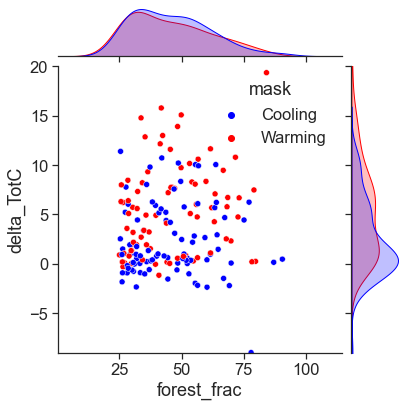

In [93]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import datetime
import csv
from netCDF4 import Dataset
from scipy import stats

import seaborn as sns
plt.style.use('seaborn-ticks')
sns.set_context("notebook", font_scale=1.5)

title_size  = 17
marker_size = 7
stepsize    = 0.01
label_size  = 15
border_size = 1.0
tick_size   = 16
legend_size = 10
line_width  = 0.5
rotation    = 45
text_size   = 10
unit_size   = 11
box_width   = 0.22
box_linewidth=1
max_min_markersize=3
markersize=50
alpha=1.0

def read_data(fname,var):
    pt=Dataset(fname, 'r')
    data=pt.variables[var][:]
    return data

def mask_data(forestdiff,data,bioenergydiff,diff_threshold):
    data=np.where(forestdiff<=diff_threshold, np.nan,data)
    data=np.where(bioenergydiff<=diff_threshold, np.nan,data)
    return data

def fillmissing(data,missVal):
    data=np.where(data>=missVal, np.nan,data)
    return data

def fillmissing_lucc(data):
    data=np.where(data>=1.00001, np.nan,data)
    data=np.where(data<0.0, np.nan,data)
    return data

def remove_nandata(forest,data):
    data=data[~np.isnan(forest)]
    return data

def set_label(ax_current,ssp,crop):
    ax_current.spines['top'].set_visible(False)
    ax_current.spines['right'].set_visible(False)
    ax_current.spines['bottom'].set_linewidth(border_size)
    ax_current.spines['left'].set_linewidth(border_size)
    ax_current.set_xlabel(r"$\Delta$"+" $frac$$_{forest}$ (2100-2015) (%)",fontsize=label_size)
    ax_current.set_ylabel(r"$\Delta$"+"Vegetation C (kg C/m$^2$)\n(2100 vs. 2015)",fontsize=label_size+1)

def read_one_ensemble(caseid):
    fname=data_dir +var+"_SSP126Lu-REFOREST_"+caseid+"_2015_2100.nc"
    vegc = read_data(fname, "value")
    vegc=fillmissing(vegc,missVal)
    vegc = vegc / 1000.
    diff=vegc[-1,:,:] - vegc[0,:,:]
    return diff

def subplot(crop):
    frac_changes=True
    fname=data_dir + "forest_frac_2015_2100_SSP126Lu-REFOREST.nc"
    forest = read_data(fname, "biofrac")
    forest =fillmissing_lucc(forest)
    forest = forest *100.
    forestfrac=(forest[yeari_dic[2060],:,:] - forest[0,:,:])
    
    fname=data_dir + "bioenergy_frac_2015_2100_SSP226Lu-BIOCROP.nc"
    bioenergy = read_data(fname, "biofrac")
    bioenergy =fillmissing_lucc(bioenergy)
    bioenergy = bioenergy *100.
    bioenergydiff=(bioenergy[yeari_dic[2060],:,:] - bioenergy[0,:,:])

    ensbase=np.empty((ens_size,192,288))
    for caseid,i in zip(["ensemble1","ensemble2","ensemble3"],np.arange(ens_size)):
        ensbase[i,:,:] = read_one_ensemble(caseid)
    diffval = np.nanmean(ensbase,axis=0)
    
    forestfrac = forestfrac.reshape(nlat*nlon)
    forestdiff = forestfrac
    diffval = diffval.reshape(nlat*nlon)
    bioenergydiff = bioenergydiff.reshape(nlat*nlon)
        
    diff_threshold   = 25.0
    forestfrac = mask_data(forestdiff,forestfrac,bioenergydiff,diff_threshold)
    forestfrac = mask_data(forestdiff,forestfrac,bioenergydiff,diff_threshold)
    diffval = mask_data(forestdiff,diffval,bioenergydiff,diff_threshold)
    diffval = mask_data(forestdiff,diffval,bioenergydiff,diff_threshold)
    bioenergydiff = mask_data(forestdiff,bioenergydiff,bioenergydiff,diff_threshold)
    bioenergydiff=mask_data(forestdiff,bioenergydiff,bioenergydiff,diff_threshold)
        
    var2 = "TSA"
    ensbase=np.empty((ens_size,2,192,288))
    for caseid,i in zip(["ensemble1","ensemble2","ensemble3"],np.arange(ens_size)):
        fname=data_dir +var2+"_SSP226Lu-BIOCROP_"+caseid+"_2015_2100_JJA.nc"
        tsa = read_data(fname, "value")
        tsa=fillmissing(tsa,missVal)
        ensbase[i,:,:,:] = tsa
    tsa_ssp2 = np.nanmean(ensbase,axis=0)
    
    ensbase=np.empty((ens_size,2,192,288))
    for caseid,i in zip(["ensemble1","ensemble2","ensemble3"],np.arange(ens_size)):
        fname=data_dir +var2+"_SSP126Lu-REFOREST_"+caseid+"_2015_2100_JJA.nc"
        tsa = read_data(fname, "value")
        tsa=fillmissing(tsa,missVal)
        ensbase[i,:,:,:] = tsa
    tsa_ssp1 = np.nanmean(ensbase,axis=0)
    
    factor_array= tsa_ssp2[-1,:,:] - tsa_ssp1[-1,:,:]
    factor_array = factor_array.reshape(nlat*nlon)
               
    ### delete nan values
    rs =  forestfrac
    rs2= bioenergydiff
    clm=diffval
    temp = np.where(np.isnan(rs))
    rs=np.delete(rs,temp)
    clm=np.delete(clm,temp)
    factor_after=np.delete(factor_array,temp)
    rs2=np.delete(rs2,temp)

    temp2 = np.where(np.isnan(clm))
    rs=np.delete(rs,temp2)
    clm=np.delete(clm,temp2)
    factor_after=np.delete(factor_after,temp2)
    rs2=np.delete(rs2,temp2)

    temp3 = np.where(np.isnan(factor_after))
    rs=np.delete(rs,temp3)
    clm=np.delete(clm,temp3)
    factor_after=np.delete(factor_after,temp3)
    rs2=np.delete(rs2,temp3)

    temp4 = np.where(np.isnan(rs2))
    rs=np.delete(rs,temp4)
    clm=np.delete(clm,temp4)
    factor_after=np.delete(factor_after,temp4)
    rs2=np.delete(rs2,temp4)
    
    ### fitted line
    mask = [""]*(len(rs))
    coolingdata=np.zeros(len(rs))
    warmingdata=np.zeros(len(rs))
    coolingdata[:]=np.nan
    warmingdata[:]=np.nan
    cdata=[]
    wdata=[]
    for i in np.arange(len(rs)):
        if (factor_after[i]<=0):
            mask[i] = "Cooling"
            coolingdata[i] = clm[i]
            cdata=np.append(cdata,clm[i])
        else:
            mask[i] = "Warming"
            warmingdata[i]=clm[i]
            wdata=np.append(wdata,clm[i])

    rs_plot = rs
    clm_plot = clm
    m, b = np.polyfit(rs_plot,clm_plot, 1) # m = slope, b=intercept    
    
    fnmo="temp.csv"
    output_data=np.column_stack((rs,clm,mask))
    np.savetxt(fnmo, output_data, delimiter=',', fmt='%s')
    data = pd.read_csv(fnmo, index_col=0, parse_dates=True, names=['forest_frac', 'delta_TotC','mask'], skiprows=0, sep=",")
        
    ttest1=stats.ttest_ind(cdata,wdata, equal_var = False)
    
    plt.figure(figsize=(5,4.5))
    sns.jointplot(data=data, x="forest_frac", y="delta_TotC",palette=["blue","red"],hue="mask",ylim=(-9,20))
    figdir="../figures/"
    figname=figdir+"Fig4a_distribution.pdf"
#     plt.savefig(figname,bbox_inches='tight')
    set_label(ax,ssp,crop)

################
## plot figure, time series
################

var = "TOTECOSYSC"
data_dir = "../data/"
    
subplot(crop)
